## DSGE w. Feedback - Numerical Simulations

### Imports

In [8]:
%load_ext autoreload
%autoreload 2
%aimport
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import minimize

In [10]:
import model

## Simulation mechanics

In [152]:
def bound(z: float, gti: float, k: float, p:dict):
    """ Check whether we need to respect the bound on labour"""
    mu = abs(p['rho'])
    x = (z / gti) **  mu - (p['alpha'] / (k ** mu))
    if x < 0:
        return np.infty
    else:
        return ((1 - p['alpha']) / x) ** (1 / mu)


def bisection_CES(z:float, gti:float, k:float, ft_:float, p: dict, init:float=1e3):
    assert gti > 0, "Negative income"
    
    mu = abs(p['rho'])
    gr = p['gamma'] * (1 + p['interest'])
    kmu = k ** mu
    
    pt1 = -1 * (1 - p['alpha']) * kmu 
    pt2 = 2 * ft_ * z + z
    pt3 = 4 * gti * gr
    pt4 = 2 * p['alpha'] * gr
    
    def ces(n: float):
        temp = (p['alpha'] / kmu) + ((1 - p['alpha']) / (n ** mu))
        return z * (temp ** (-1 / mu))
    
    def val(n:float):
        n2 = n ** 2
        y = z * (ces(n) ** -1)
        x = pt1 * (pt2 - 2 * z * gr * n2 + pt3 * n2 * y - 2 * gti * y)
        x = x + pt4 * n2 * (n ** mu) * (z - 2 * gti * y)
        return x
    
    def func(n:float):
        return np.abs(val(n))
    
    n0 = 1e-9
    b = bound(z, gti, k, p)
    if b == np.infty:
        res = minimize(func, n0, tol=1e-6)
    else:
        bnds = (1e-10, min([init, bound(z, gti, k, p)]))
        res = minimize(func, n0, bounds=[bnds], tol=1e-6)

    return res.x[0], ces(res.x[0])

In [122]:
def test_bound():
    p = dict(rho=-5.5, alpha=1/3)
    print("Bound (inf) k=10, gti=1 = {}".format(bound(1, 10, 1, p)))
    print("Bound (0.9289) k=1, gti=10 = {}".format(bound(1, 1, 10, p)))
    
test_bound()

Bound (inf) k=10, gti=1 = inf
Bound (0.9289) k=1, gti=10 = 0.9289310736134464


In [209]:
def step(t: float, x: np.ndarray, p: dict):
    # Starting variables
    z_, c_, n_, b_, w_, k_, q_, gt_, ft_, news_, inc_, xiz_, xin_ = x
    
    # Random technology process
    rand = np.random.normal(0, p['sigmaZ'])
    xiz = p['etaZ'] * xiz_ + np.sqrt(1 - p['etaZ'] ** 2) * rand
    z = p['zbar'] * np.exp(xiz)
        
    # Income and Investment
    income = (w_ * n_ + b_ + q_ * k_) / (1 + p['inflation'])
    
    # Capital Markets
    k = (1 - p['depreciation']) * k_ + income * (1 - gt_)
    
    k = max([k, 0.1])
    
    # Household decision
    gti = gt_ * income
    assert gti > 0, "Negative income"
    n, c = bisection_CES(z, gti, k, ft_, p)
    b = (gti - c) * (1 + p['interest'])
    
    # Firm decisions
    temp = (p['alpha'] * k ** p['rho'] + (1 - p['alpha']) * n ** p['rho']) 
    temp = temp ** ((1 / p['rho']) - 1)
    w = (1 - p['alpha']) * z * temp * (n ** (p['rho'] - 1))
    q = p['alpha'] * z * temp * (k ** (p['rho'] - 1))
    
    # News
    xin = np.random.normal(0, p['sigmaN'])
    info = p['n_cons']*(c/c_ - 1)
    news = p['n_persistence'] * news_ + (1 - p['n_persistence']) * info + xin
    news = np.tanh(p['n_theta'] * news)
    
    if t > 300 and t < 400:
        if p['shock'] == -1:
            news = -1.0
        elif p['shock'] == 1:
            news = 1.0
    
    # Household modifiers
    gt = 0.5 * (p['g_max'] + p['g_min'] - news * (p['g_max'] - p['g_min']))
    ft = 0.5 * (p['f_max'] + p['f_min'] - news * (p['f_max'] - p['f_min']))
    
    return z, c, n, b, w, k, q, gt, ft, news, income, xiz, xin

In [206]:
def simulate(start: np.ndarray, p: dict, t_end: float = 1e3):
    x = np.empty((int(t_end), len(start)))
    x[0, :] = start
    for t in range(1, int(t_end)):
        x[t, :] = step(t, x[t - 1, :], p)
    cols = ['z', 'c', 'n', 'b', 'w', 'k', 'q', 'gt', 'ft', 'news', 'income', 'xiz', 'xin']
    df = pd.DataFrame(x, columns=cols)
    df.loc[:,'inv'] = 100*(1-df.loc[:,'gt'])
    df.loc[:,'bc'] = df.b / df.c
    return df

----
## Interactive Analysis

<IPython.core.display.Javascript object>


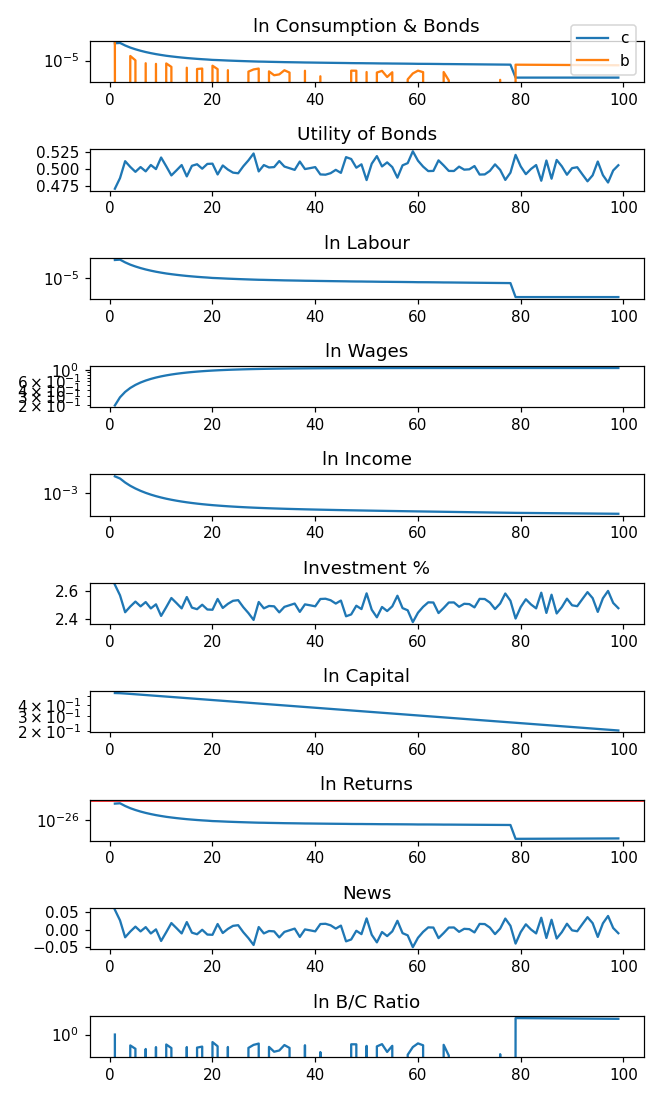

In [208]:
p = {'etaZ': 0.2, 'sigmaZ': 0., 'zbar': 1.0, 'sigmaN': 0.2, 
     'inflation': 0.0, 'interest': 0.01, 'depreciation': 0.01, 
     'g_min': 0.95, 'g_max': 0.99999, 'f_min': 0.0, 'f_max': 1.0, 
     'n_cons': 1, 'n_theta': 0.1, 'n_persistence': 0.8, 
     'gamma': 1.0, 'alpha': 0.33, 'rho': -4.9, 'shock': 0.0}

s = dict(z=1, c=10, n=1, b=0.1, w=.1, k=0.5, q=0.1, 
         gt=0.8, ft=1.5, income=1, news=1, xiz=0, xin=0)
start = np.array([v for _,v in s.items()])

T = 100
np.random.seed(40)
view = (1, int(T))

df = simulate(start, p, T)
df = df.iloc[view[0]:view[1],:]

graphs = {
        'ln Consumption & Bonds' : [df.loc[:,['c','b']], True],
        'Utility of Bonds' : [df.ft, False],
        'ln Labour' : [df.n, True],
        'ln Wages' : [df.w, True],
        'ln Income' : [df.income, True],
        'Investment %' : [df.inv, False],
        'ln Capital' : [df.k, True],
        'ln Returns' : [df.q, True],
        'News' : [df.news, False],
        'ln B/C Ratio' : [df.bc, True],
    }

axs = model.simulation_graph(graphs, size = (6, 10))
axs['ln Returns'].axhline(p['interest'], color='red', linewidth=0.5)

In [143]:
fig, ax = plt.subplots(1,2,figsize = (6,3))

k = np.logspace(-4,4, 1000)
income = [.01,.1,1,10,100]
ft = .1
z = 1
p = {'etaZ': 0.2, 'sigmaZ': 0.8, 'zbar': 1.0, 'sigmaN': 0.2, 
     'inflation': 0.01, 'interest': 0., 'depreciation': 0., 
     'g_min': 0.7, 'g_max': 0.9, 'f_min': 1.0, 'f_max':10, 
     'n_cons': 1, 'n_theta': 1, 'n_persistence': 0.1, 
     'gamma': 1.0, 'alpha': 1/3, 'rho': -7.345, 'shock': 0.4}



for inc in income:
    sol_n = []
    sol_c = []
    for kap in k:
        n, c = bisection_CES(z, inc, kap, ft, p)
        sol_n.append(n)
        sol_c.append(c)
    ax[0].plot(k,sol_n, label=r'Income =' + str(inc))
    ax[1].plot(k,sol_c, label=r'Income =' + str(inc))
    
ax[0].legend()
ax[1].legend()
#ax[0].set_yscale('log')
ax[0].set_xscale('log')
#ax[1].set_yscale('log')
ax[1].set_xscale('log')

<IPython.core.display.Javascript object>

1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1.1185432035923074e-06
1.2806262499804382e-06
1.4662170353463538e-06
1.6787250081435708e-06
1.9220541066941545e-06
2.2006744776010

0.009462931503850946
0.009462931503850946
0.009462931503850946
0.009462931503850946
0.009462931503850946
0.009462931503850946
0.009462931503850946
0.009462931503850946
0.009462931503850946
0.009462931503850946
0.009462931503850946
0.009462931503850946
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.00946293150

0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.009462931503850944
0.00946293150

0.0010505304241488563
0.0010176609464463743
0.0013190486579291807
0.001298101831444295
0.0016986621346608548
0.002228603879480448
0.002211338442513114
0.0029108543441573034
0.002895609513103677
0.003819114667764881
0.0038050844079414708
0.005025031992213604
0.005011767449579876
0.006624288889157923
0.006611517489748782
0.006600574622476036
0.008731585692077963
0.008720863654473613
0.011540736700692751
0.011530147127370775
0.015262730550309522
0.01525220745927619
0.020194253446931026
0.0201837572010103
0.02672878403704539
0.02671827908334836
0.035388231231762934
0.03537769127076141
0.04686445138146174
0.04685389100928082
0.062071464254047484
0.062061048279585015
0.082199654033554
0.08219086112974751
0.09472172023284452
0.09470997408003123
0.09469972568137089
0.09469078295438534
0.09468297871340065
0.09467616738005903
0.09467022214324076
0.09466503250353583
0.09466050214755956
0.09465654710579513
0.09465309415461456
0.09465007942894438
0.094647447216919
0.09464514891197073
0.094643142101

0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945
0.09462931503850945


0.0029130659677023157
0.0029130164367897255
0.002912973986032158
0.0038588189025981615
0.003858777600512792
0.0038587422016115886
0.003858711862149953
0.005111711977186113
0.00511168247200074
0.0051116571845344246
0.0051116355115228655
0.006771518297041699
0.006771497330312416
0.006771479362211714
0.006771463964585929
0.006771450769688254
0.008970410752989988
0.008970398568704033
0.008970388138630474
0.00897037921004066
0.011883561674673252
0.011883556971068403
0.011883553012251512
0.011883549686276078
0.015743039293260475
0.015743060247989157
0.01574307865251253
0.01574309482234946
0.020856059393043448
0.020856221813940895
0.020856363756003297
0.02085648778711134
0.02762682292002442
0.027627830354185125
0.02762871050982635
0.027629479427230944
0.036571044636212614
0.03657709787091333
0.036582391911785896
0.03658702112784322
0.04825163765660457
0.048286650982763246
0.04831742463871577
0.0483444507436113
0.04836816930429061
0.06298579532287475
0.06314367453957796
0.0632848388074581
0.06

0.6674711076870895
0.6674711076872433
0.6674711076871412
0.6674711076869617
0.6674711076875539
0.6674711076865332
0.6674711076873239
0.6674711076867899
0.6674711076863985
0.6674711076867622
0.6674711076867474
0.6674711076869034
0.6674711076867895
0.6674711076869242
0.6674711076868727
0.6674711076873711
0.6674711076872536
0.6674711076873189
0.6674711076871482
0.6674711076872853
0.6674711076864396
0.6674711076873185
0.6674711076869863
0.6674711076871356
0.6674711076864996
0.6674711076868258
0.6674711076870768
0.6674711076873434
0.6674711076870453
0.6674711076871302
0.6674711076867518
0.6674711076869048
0.6674711076873366
0.6674711076871477
0.6674711076867531
0.6674711076868975
0.6674711076871268
0.6674711076871976
0.6674711076863251
0.6674711076874223
0.6674711076874669
0.6674711076869742
0.667471107687056
0.6674711076873092
0.6674711076872676
0.6674711076868662
0.6674711076870816
0.6674711076867712
0.6674711076863742
0.6674711076867035
0.6674711076874074
0.6674711076872041
0.66747110768

0.0001041950344901763
0.0001380264361325727
0.00013961120025172377
0.00014126069143480247
0.00014294750249918748
0.00014445155148241727
0.00019289132294871686
0.00019331497521284105
0.00019377541908743726
0.0001942398602994273
0.00025787653278667083
0.0002584501947970076
0.0002589027457178536
0.0002592141980394779
0.0003435249975123366
0.000343548942260885
0.00034341257954232025
0.00034315039728788436
0.0004541439160437005
0.00045139392663870996
0.0004491797924118442
0.0004475173210531218
0.0005893043076638844
0.0005817431169704847
0.0005751742898777567
0.0005695137865559363
0.0007479928061422975
0.0007425094806328809
0.0007378390006329356
0.000733865818386603
0.0009677041332367062
0.0009638985866055663
0.0009606620891180225
0.0009579082414400155
0.0012687649723762988
0.0012664432033463345
0.0012644681791056439
0.0012627866627499952
0.0016710876162326113
0.0016694670168733868
0.0016680841759948743
0.001666903501759751
0.00220677484682079
0.0022056335010256127
0.0022046576251989764
0.00

0.7043680898483332
0.7043680922542
0.7043680933889914
0.7043680885751374
0.7043680894890184
0.7043680886150381
0.7043680884352996
0.7043680888916614
0.7043680884358097
0.7043680926811093
0.7043680884361986
0.7043680884620214
0.7043680893364845
0.7043680922737596
0.7043680884367215
0.7043680885508888
0.7043680904686374
0.7043680887592153
0.7043680923166621
0.7043680887623985
0.7043680889542142
0.7043680920786216
0.7043680897186195
0.7043680922030658
0.7043680922918127
0.7043680923240397
0.7043680892882398
0.7043680884373237
0.7043680884373396
0.7043680923709408
0.7043680905238059
0.7043680917961563
0.7043680931893976
0.7043680927268666
0.7043680920688359
0.7043680917560605
0.7043680910880404
0.7043680910403523
0.7043680884522899
0.7043680884570188
0.7043680885264796
0.7043680885546221
0.7043680885960392
0.7043680886388294
0.7043680886613423
0.7043680886568636
0.7043680886934708
0.7043680887456214
0.7043680887233306
0.7043680887385088
0.7043680887365587
0.7043680887479297
0.7043680887674

0.00015259417492993635
0.00015516883418517478
0.0001583562582307273
5.382509173714449e-05
5.481526788196358e-05
5.573908959725432e-05
5.6577150677933323e-05
5.731173859574427e-05
5.792776061434683e-05
5.8413724673361796e-05
5.876279067478939e-05
5.897384923807851e-05
5.905245373209835e-05
5.9011255802186245e-05
5.886949094254402e-05
5.865120642197167e-05
5.7723320004741465e-05
5.617709189875578e-05
5.473246201416893e-05
5.340960880725261e-05
0.00015664459128189305
0.0001534681641139214
0.00015067451775472974
0.0001482368853897046
0.00014612266915177676
0.0001442974514742116
0.00014272755404997895
0.000141381506488298
0.00014023077244171444
0.00013925000535445125
0.00013841702723371992
0.00013771265687510478
0.00013712046914683346
0.0001366265316671798
0.0001362191480013552
0.0001358886212914093
0.00013562704537656097
0.00013542812642385082
0.00013528703503401014
0.0001352002868722826
0.00013516565149474837
0.00013518208549130188
0.00013524968903919576
0.00013536968314705234
0.000135544

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


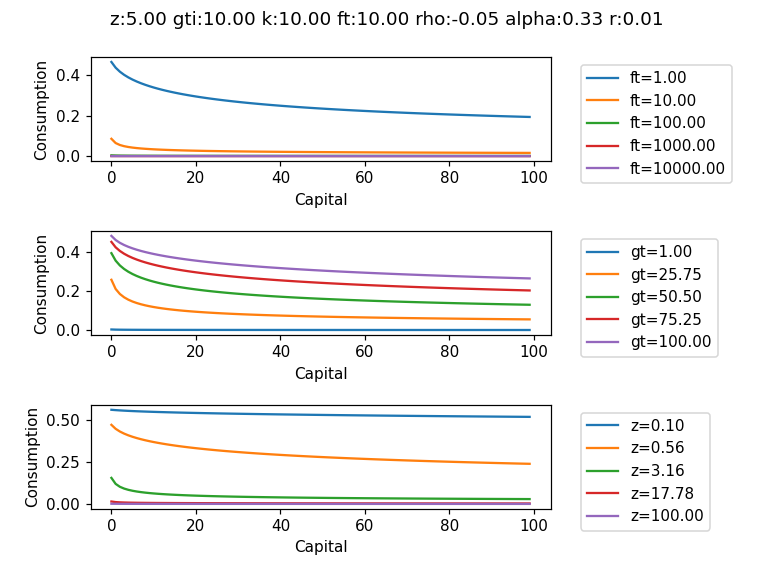

In [164]:
def test_CES(z0:float, gti:float, k0:float, ft:float, rho:float, gamma:float, 
             interest:float, alpha:float, init:float=1e3):
    
    p = dict(rho=rho, interest=interest, alpha=alpha, gamma=gamma)
    
    n_k = 100
    n = 5
    
    c_f = np.empty((n_k, n))
    c_g = np.empty((n_k, n))
    c_z = np.empty((n_k, n))
    
    f = np.logspace(0,4,n)
    g = np.linspace(1,100,n)
    z = np.logspace(-1,2,n)
    
    fig, ax = plt.subplots(nrows=3, ncols=1)
    
    for i,k in enumerate(np.arange(1,n_k+1)):
        for ii in range(n):
            c_f[i,ii],_ = bisection_CES(z0, gti, k, f[ii], p)
            c_g[i,ii],_ = bisection_CES(z0, g[ii], k, ft, p)
            c_z[i,ii],_ = bisection_CES(z[ii], gti, k, ft, p)      
    
    for ii in range(n):
        ax[0].plot(c_f[:,ii], label="ft={:.2f}".format(f[ii]))
        ax[1].plot(c_g[:,ii], label="gt={:.2f}".format(g[ii]))
        ax[2].plot(c_z[:,ii], label="z={:.2f}".format(z[ii]))
    
    for a in ax:
        a.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        a.set_ylabel('Consumption')
        a.set_xlabel('Capital')
    
    v = dict(z=z0, gti=gti, k=k0, ft=ft, rho=rho, alpha=alpha, r=interest)
    title = ' '.join(['{}:{:.2f}'.format(k,val) for k,val in v.items()])
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()
    

test_CES(5.0, 10.0, 10.0, 10.0, -5.0e-2, 1.0, 0.01, 0.33)
#test_CES(5.0, 10.0, 10.0, 10.0, -5.0, 1.0, 0.01, 0.6)
#test_CES(5.0, 10.0, 10.0, 10.0, -50.0, 1.0, 0.01, 0.33)

In [8]:
param_bounds = {
    # Restrict noise params to be constant
    'etaZ': (0.2,0.2), 'sigmaZ': (0.8,0.8), 'sigmaN': (0.2,0.2), 
    # Realistic monthly values - 0% to 5%
    'inflation': (0.0,0.05), 'interest': (0.0,0.05), 'depreciation': (0.0,0.05),
    # Saving and bond parameters
    'g_min': (0.0,0.99), 'g_max': (0.0,0.99), 'f_min': (0.0,1e1), 'f_max': (1e1,1e3),
    # News parameters
    'n_cons': (0.1,10), 'n_theta': (0.1,10), 'n_persistence': (0.0,0.99),
    # Production & Household
    'zbar': (1.0,1.0), 'gamma': (1.0,10.0), 'alpha': (0.1,0.9), 'rho': (-1e4,-1e-1), 
    # No shocks for now
    'shock': (0.0,0.0)}

n = 5
param_steps = {'etaZ': 0, 'sigmaZ': 0, 'sigmaN': 0, 'inflation': 0, 'interest': 0, 'depreciation': 0,
    'g_min': n, 'g_max': n, 'f_min': n, 'f_max': n, 'n_cons': n, 'n_theta': n, 'n_persistence': n,
    'zbar': 0, 'gamma': 0, 'alpha': n, 'rho': n, 'shock': 0}

In [9]:
# Generate the whole set of parameters
params = {'etaZ': 0.2, 'sigmaZ': 0.8, 'zbar': 1.0, 'sigmaN': 0.2, 
          'inflation': 0.01, 'interest': 0.01, 'depreciation': 0.01, 
          'g_min': 0.8, 'g_max': 0.99, 'f_min': 1.0, 'f_max': 100, 
          'n_cons': 1, 'n_theta': 1, 'n_persistence': 0.8, 
          'gamma': 1.0, 'alpha': 0.5, 'rho': -1, 'shock': 0.0}

constants = [k for k,v in param_steps.items() if v==0]
ranges = {k:np.linspace(*v, param_steps[k]) for k,v in param_bounds.items()}
ranges = {k:v for k,v in ranges.items() if v.size!=0}

In [10]:
results = pd.DataFrame(columns = list(ranges.keys()))

In [11]:
from itertools import product

var = list(ranges.keys())

for tup in product(*list(ranges.values())):
    # Generate unique parameter set
    p = dict(params)
    for combo in zip(var, tup):
        p[combo[0]] = combo[1]
    #df = simulate(start)


In [12]:
def dead_economy(df, epsilon):
    return df.c.iloc[-1] < epsilon

In [23]:
# CES
def lhs_CES(cons: float, z: float, k:float, alpha: float, gamma: float, r: float, rho: float) -> float:
        pt1 = 2 * gamma * (1+r) / ((z ** 2) * (1 - alpha) ** (2 / rho))
        pt2 = cons ** 2
        pt3 = (1 - alpha*(z * k / cons) ** rho) ** ((2 - rho) / rho)
        print(pt1, pt2, pt3)
        return pt1 * pt2 * pt3

def rhs_CES(cons: float, gti: float, ft: float) -> float:
    return 1 - (ft * cons) / (gti - cons)
    

def bisection_CES(z:float, income:float, k:float, gt_:float, ft_:float, p:dict, err:float=1e-2)->float:
    assert gt_ * income > 0
    # Define the left and right hand sides of the equations
    diff = lambda c: rhs_CES(c, gt_ * income, ft_) - lhs_CES(c, z, k, p['alpha'], p['gamma'], p['interest'], p['rho'])
    
    # Initial guess at the next options for 
    a = k * z * (p['alpha'] ** (1 / p['rho'])) 
    if a > gt_ * income:
        print("Bad boundaries, setting c=g")
        return gt_ * income
    
    x = [a, 0.5 * (gt_*income + a), gt_*income]
    print(x)
    
    #guess = np.min([gt_*income, k * z * (p['alpha'] ** (1 / p['rho']))])
    #x = [0, guess / 2, guess]
    abs_lst = [abs(diff(i)) for i in x[:2]]
    
    # Apply bi-section method
    while min(abs_lst) >= err:
        test = np.sign([diff(i) for i in x])
        if test[0] == test[1]:
            x = [x[1], (x[1] + x[2]) / 2, x[2]]
        elif test[1] == test[2]:
            x = [x[0], (x[0] + x[1]) / 2, x[1]]

        abs_lst = [abs(diff(i)) for i in x[:2]]

    return x[np.argmin(abs_lst)]